# AS - TME3 - Modèles Simples

**Analyse des frontières de décisions obtenues par apprentissage de modèles simples avec torch.**

* Université Pierre et Marie Curie (UPMC)
* Master Données Apprentissage et Connaissances (DAC)
* Professeurs Patrick Gallinari et Ludovic Denoyer
* Etudiants Rémi Cadène et Michael Chen

## Sommaire

1. Introduction
2. Comparaisons de modèles
    1. Modèle Linéaire
        1. 2Gauss
        2. XOR
    2. Modèle Linéaire avec noyau
        1. XOR
        2. Spirale
    3. Réseau de neurones deux couches
        1. XOR
    4. Réseau de neurones trois couches
        1. Spirale
3. Comparaisons des critères MSE et Margin
    1. Modèle Linéaire, 2Gauss
    2. Modèle Linéaire avec noyau, XOR
    3. Réseau de neurones, XOR
    4. Modèle Linéaire, Outliers

#1. Introduction

Dans ce rapport de Travail sur Machines Encadré, nous avons dans une premère section comparé les frontières de décision de quatre modèles, **linéaire, linéaire avec noyau et réseau de neurones deux couches, réseau de neurones trois couches **, en fonction de leur capacité à apprendre trois datasets jouets, **2 gaussiennes 2 classes (2Gauss), 4 gaussiennes 2 classes (XOR), 3 bananes 3 classes (Spirale)**. Tous nos modèles ont été entraînés avec pour critère celui des moindres carrés. Dans une seconde section, nous avons mise en évidence les différences entre le critère des moindres carrés et le critère à marge paramétrable, aussi connu sous le nom de "Hinge Loss" dans sa version par défaut. Pour ce faire, nous avons entraîné les précédents modèles sur certaines données, dont un dataset créant un outlier, et avons comparé leurs frontières de décision.

## Dépendances

In [1]:
require 'nn'
require 'gnuplot'
require 'image'

## Fonctions Lua/Torch

### Génération de datasets

In [2]:
function generate_gauss(mu,sigma,nbEx)
   local x = torch.randn(nbEx, #mu)
   for i = 1,#mu do
      x[{{},{i}}] = x[{{},{i}}] * sigma[i] + mu[i]
   end
   return x
end

function generate_gaussDataset(gaussParams, nbEx)
   local x = generate_gauss(gaussParams[1][1], gaussParams[1][2], nbEx)
   local y = torch.ones(nbEx) * gaussParams[1][3]
   for i = 2,#gaussParams do
      x = x:cat(generate_gauss(gaussParams[i][1], gaussParams[i][2], nbEx),1)
      y = y:cat(torch.ones(nbEx) * gaussParams[i][3])
   end
   return x,y
end

function generate_spiral(N, D, K, criterion)
    --[[N: Number of points per class
        D: dimensionality
        K: number of classes
        MSE: return 3 dim instead of 1]]
    local x = torch.zeros(N*K,D)
    criterion = criterion or 'MSE'
    local y
    if criterion == 'MSE' then
        y = torch.zeros(N*K,K)
    else
        y = torch.zeros(N*K)
    end
    local ix, r, t, X1, X2
    for j = 1, K do
        r  = torch.linspace(0.0, 1, N)
        t  = torch.linspace((j-1)*4, j*4, N) + torch.randn(N)*0.2
        X1 = torch.sin(t)
        X2 = torch.cos(t)
        for i = 1, N do
            xi = N*(j-1)+i
            x[{xi,1}] = r[i]*X1[i]
            x[{xi,2}] = r[i]*X2[i]
            if criterion == 'MSE' then
                y[{xi,j}] = 1
            else
                y[xi] = j
            end
        end
    end
    return x, y
end

### Affichage des frontières de décisions

In [3]:
function toPlot2D(x,label,color)
   return {label, x[{{},1}], x[{{},2}], 'p ls 1 lc rgb "'..color..'"'}
end

function getRegionGrid(x,nbPoints)
   local xmin = x:min(1)[1]
   local xmax = x:max(1)[1]
   local axe1 = torch.linspace(xmin[1], xmax[1],nbPoints)
   local axe2 = torch.linspace(xmin[2], xmax[2],nbPoints)
   local gridX = torch.zeros(axe1:size(1) * axe2:size(1),2)
   i = 1
   for i1 = 1, axe1:size(1) do
      for i2 = 1, axe2:size(1) do
         gridX[i][1] = axe1[i1]
         gridX[i][2] = axe2[i2]
         i = i + 1
      end
   end
   return gridX
end

function plot_binaire(model, x, y, labels, colors, colorsReg, name)
    toPlot = {}
    -- Region
    xGrid = getRegionGrid(x,500)
    xGridInputs = xGrid
    yGrid = model:forward(xGrid)
    yGrid = yGrid:sign()
    indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
    for i = 1, #labels do
       local selected = indices[yGrid:eq(labels[i])]
       table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
    -- Points
    indices = torch.linspace(1,y:size(1),y:size(1)):long()
    for i = 1, #labels do
       local selected = indices[y:eq(labels[i])]
       table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
    end
    gnuplot.pngfigure(name)
    gnuplot.plot(toPlot)
    gnuplot.close()
end

function plot_binaire_kernel(model, x, y, labels, colors, colorsReg, name)
    toPlot = {}
    -- Region
    xGrid = getRegionGrid(x,500)
    xGridInputs = torch.cat(xGrid, torch.cmul(xGrid[{{},1}], xGrid[{{},2}]),2)
    yGrid = model:forward(xGridInputs)
    yGrid = yGrid:sign()
    indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
    for i = 1, #labels do
       local selected = indices[yGrid:eq(labels[i])]
       table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
    -- Points
    indices = torch.linspace(1,y:size(1),y:size(1)):long()
    for i = 1, #labels do
       local selected = indices[y:eq(labels[i])]
       table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
    end
    gnuplot.pngfigure(name)
    gnuplot.plot(toPlot)
    gnuplot.close()
end

function plot_multiclass(model, x, y, labels, colors, colorsReg, name)
    toPlot = {}
    -- Region
    xGrid = getRegionGrid(x,500)
    yGrid = model:forward(xGrid)
    _, yGrid = yGrid:max(2)
    indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
    for i = 1, #labels do
       local selected = indices[yGrid:eq(labels[i])]
       table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
    -- Points
    _, y = y:max(2)
    indices = torch.linspace(1,y:size(1),y:size(1)):long()
    for i = 1, #labels do
       local selected = indices[y:eq(labels[i])]
       table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
    end
    gnuplot.pngfigure(name)
    gnuplot.plot(toPlot)
    gnuplot.close()
end

#2. Comparaisons de modèles

##A. Modèle Linéaire

###a. 2Gauss

In [4]:
labels = {-1,1}
gaussParams = {{{2,2},{1,1},labels[1]},
               {{-2,-2},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

-- Model Linéaire
nbIter = 100
lr = 1e-1
criterion = nn.MSECriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   output = model:forward(x)
   loss = criterion:forward(output, y)
   df_do = criterion:backward(output, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   -- print(i,loss)
end

plot_binaire(model, x, y, labels, colors, colorsReg, 'linear_2gauss.png')

On constate ci-dessous que le modèle linéaire arrive avec succès à séparer les deux classes en formant une frontière linéaire.

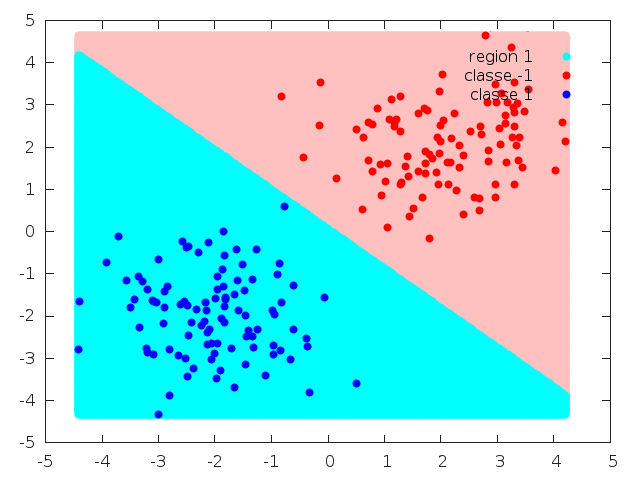

In [5]:
itorch.image(image.load('linear_2gauss.png'))

###b. XOR

In [6]:
labels = {-1,1}
gaussParams = {{{0,0},{1,1},labels[1]},
               {{5,5},{1,1},labels[1]},
               {{0,5},{1,1},labels[2]},
               {{5,0},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

-- Modele Linéaire
nbIter = 1000
lr = 1e-3
criterion = nn.MSECriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(x)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
xGridInputs = xGrid
yGrid = model:forward(xGrid)
yGrid = yGrid:sign()
indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
   local selected = indices[yGrid:eq(labels[i])]
   table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
end
-- Points
indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end
gnuplot.pngfigure('linear_xor.png')
gnuplot.plot(toPlot)
gnuplot.close()

On constate ci-dessous que le modèle linéaire n'est pas capable de séparer les deux classes, car la frontière générée est linéaire.

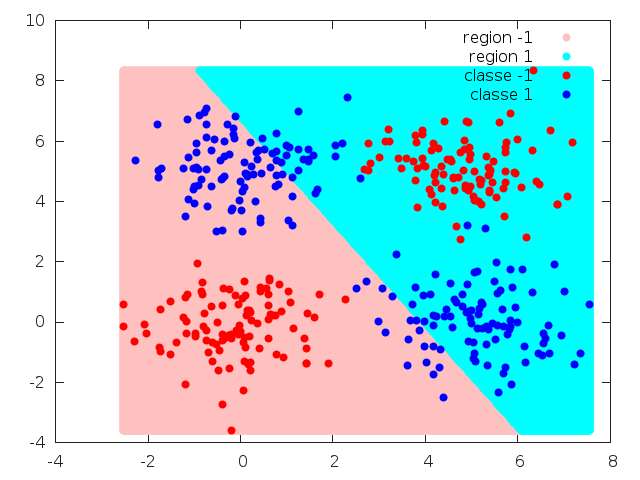

In [7]:
itorch.image(image.load('linear_xor.png'))

##B. Modèle Linéaire avec noyau

###a. XOR

In [8]:
labels = {-1,1}
gaussParams = {{{0,0},{1,1},labels[1]},
              {{10,10},{1,1},labels[1]},
              {{0,10},{1,1},labels[2]},
               {{10,0},{1,1},labels[2]}}

x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

nbIter = 1e5
lr = 3e-4
criterion = nn.MSECriterion()

inputs = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

model = nn.Linear(3,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(inputs)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(inputs, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

plot_binaire_kernel(model, x, y, labels, colors, colorsReg, 'kernel_xor.png')

On constate ci-dessous que le modèle linéaire avec noyau arrive à séparer les deux classes en générant une frontière linéaire. En effet, les deux classes sont séparées linéairement en trois dimensions. C'est pour cela qu'on le constate une frontière non linéaire en deux dimensions.

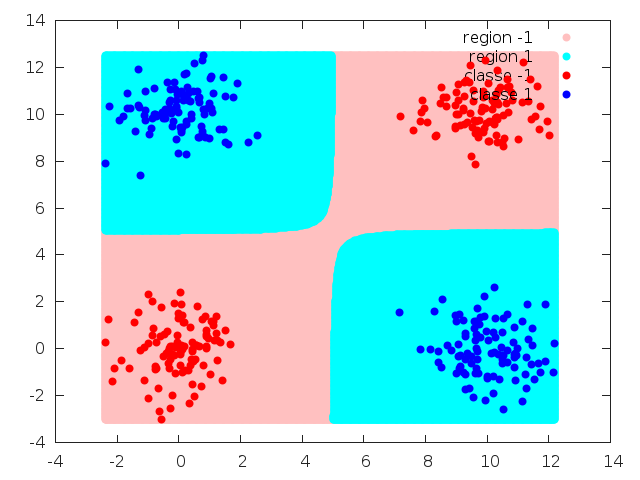

In [9]:
itorch.image(image.load('kernel_xor.png'))

###b. Spirale

In [11]:
labels = {1, 2, 3}
x,y = generate_spiral(10, 2, #labels)
colors = {"red","blue","green"}
colorsReg = {"pink", "cyan", "yellow"}

nbIter = 100
lr = 3e-4
criterion = nn.MSECriterion()

inputs = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

model = nn.Linear(3,3)
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(inputs)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(inputs, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

toPlot = {}
-- Points
_, y = y:max(2)
indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
    local selected = indices[y:eq(labels[i])]
    table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end
-- Region
xGrid = getRegionGrid(inputs,500)
xGridInputs = torch.cat(xGrid, torch.cmul(xGrid[{{},1}], xGrid[{{},2}]),2)
yGrid = model:forward(xGridInputs)
_, yGrid = yGrid:max(2)
indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
    yGrid_eq_label = yGrid:eq(labels[i])
    if yGrid_eq_label:sum() ~= 0 then
        local selected = indices[yGrid_eq_label]
        table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
end

name = 'kernel_spirale.png'
gnuplot.pngfigure(name)
gnuplot.plot(toPlot)
gnuplot.close()

On constate ci-dessous que le modèle linéaire avec noyau n'est pas capable de séparer les trois classes en formant une spirale. Ce constat n'est pas surprenant, car ajouter une troisième dimension ne permet pas de séparer ces trois classes linéairement.

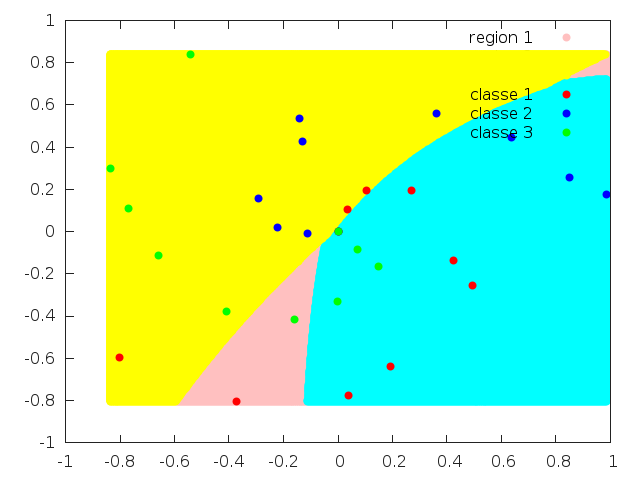

In [12]:
itorch.image(image.load(name))

##C. Réseau de neurones deux couches

###a. XOR

In [14]:
labels = {-1,1}
gaussParams = {{{0,0},{1,1},labels[1]},
              {{10,10},{1,1},labels[1]},
              {{0,10},{1,1},labels[2]},
               {{10,0},{1,1},labels[2]}}

x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

nbIter = 1e6
lr = 1e-2
criterion = nn.MSECriterion()

linear_1   = nn.Linear(2,3)
nlinearity = nn.Tanh(true)
linear_2   = nn.Linear(3,1)
for i = 1, nbIter do
    linear_1:zeroGradParameters()
    linear_2:zeroGradParameters()
    out_linear_1   = linear_1:forward(x)
    out_nlinearity = nlinearity:forward(out_linear_1)
    out_linear_2   = linear_2:forward(out_nlinearity)
    loss  = criterion:forward(out_linear_2, y)
    df_do = criterion:backward(out_linear_2, y)
    df_di_linear_2   = linear_2:backward(out_nlinearity, df_do)
    df_di_nlinearity = nlinearity:backward(out_linear_1, df_di_linear_2)
    df_di_linear_1   = linear_1:backward(x, df_di_nlinearity)
    linear_1:updateParameters(lr)
    linear_2:updateParameters(lr)
    if i % 1000 == 0 then
       print(i,loss)
    end
    if i == 1e5 then
        lr = 5e-3
    end
end
toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
xGridInputs = xGrid
grid1 = linear_1:forward(xGridInputs)
grid2 = nlinearity:forward(grid1)
yGrid = linear_2:forward(grid2)
yGrid = yGrid:sign()
indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
    yGrid_eq_label = yGrid:eq(labels[i])
    if yGrid_eq_label:sum() ~=0 then
        local selected = indices[yGrid_eq_label]
        table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
end
-- Points
indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end
name = 'net_xor.png'
gnuplot.pngfigure(name)
gnuplot.plot(toPlot)
gnuplot.close()

On constate ci-dessous qu'un réseau de neurones deux couches est capable de séparer les deux classes. 
Donc, ce modèle a appris sur sa couche cachée, composée de trois neurons, une représentation qui lui permet de capturer les distributions des gaussiennes. Cette représentation est différente de celle du modèle à noyau créée manuellement. Nous pouvons préférer cette dernière, car elle maximise la marge.

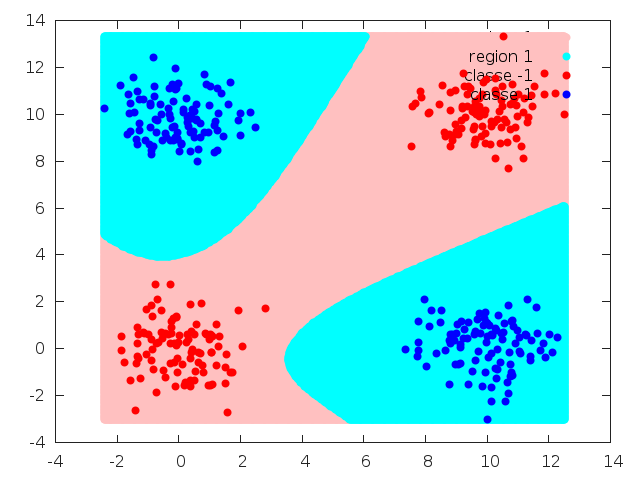

In [15]:
itorch.image(image.load(name))

##D. Réseau de neurones trois couches

###a. Spirale

In [16]:
labels = {1, 2, 3}
x,y = generate_spiral(100, 2, #labels, 'MSE')
colors = {"red","blue","green"}
colorsReg = {"pink", "cyan", "yellow"}

nbIter = 20000
lr = 1e-1
criterion = nn.MSECriterion()

model = nn.Sequential()
model:add(nn.Linear(2,100))
model:add(nn.Tanh(True))
--model:add(nn.Dropout(0.5))
model:add(nn.Linear(100,3))
model:add(nn.LogSoftMax())
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(x)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
    if i % 1000 == 0 then
       print(i,loss)
    end
end

name = 'net_spirale.png'
plot_multiclass(model, x, y, labels, colors, colorsReg, name)

1000	2,2405034299806	
2000	2,2346941200741	
3000	2,2248110090917	
4000	2,2146162296004	
5000	2,2081536679891	
6000	2,2070668069497	


7000	2,2067865024644	
8000	2,2065518081452	


9000	2,206308709648	
10000	2,2060454190134	
11000	2,2057542569793	
12000	2,2054290056706	
13000	2,2050657754971	
14000	2,2046647463017	
15000	2,204230395482	


16000	2,2037693150228	
17000	2,2032874191347	
18000	2,2027889045061	
19000	2,2022773704919	
20000	2,2017575605208	


On constate ci-dessous qu'un réseau de neurones trois couches, avec 100 neurones dans sa couche cachée, est capable d'apprendre des représentations beaucoup plus complexes, et ainsi de capturer la distribution de chacune des classes.

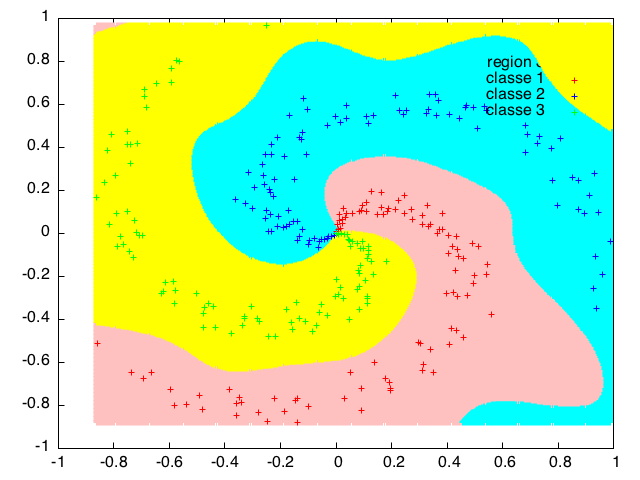

In [17]:
itorch.image(image.load(name))

#3. Comparaisons des critères MSE et Margin

Le MSECriterion est un critère qui mesure la moyenne des erreurs au carré entre $n$ éléments. Il est plus souvent utilisé pour optimiser un modèle dans le cas d'un problème de régression, mais on peut aussi l'utiliser pour le cas d'un problème de classification binaire ou multi-classe. Il est défini comme suit :  $$ loss(x, y) = |f(x) - y|^2 $$
Ce critère cherche donc à minimiser la distance entre f(x) et son label y.

Le MarginCriterion est un critère qui sert à optimiser un modèle dans le cas d'un problème de classification binaire. Lorsque le vecteur $margin$ est égal à 1, ce critère est appelé hinge loss. Il est défini comme suit : $$ loss(x, y) = max(0, margin - y*f(x)) $$

##A. Modèle linéaire, 2Gauss

In [18]:
labels = {-1,1}
gaussParams = {{{2,2},{1,1},labels[1]},{{-2,-2},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

In [21]:
nbIter = 100
lr = 1e-1
criterion = nn.MarginCriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   output = model:forward(x)
   loss = criterion:forward(output, y)
   df_do = criterion:backward(output, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

name1 = 'linear_2gauss_Margin.png'
plot_binaire(model, x, y, labels,colors, colorsReg, name1)

In [22]:
nbIter = 100
lr = 1e-1
criterion = nn.MSECriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   output = model:forward(x)
   loss = criterion:forward(output, y)
   df_do = criterion:backward(output, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

name2 = 'linear_2gauss_MSE.png'
plot_binaire(model, x, y, labels, colors, colorsReg, name2)

On constate ci-dessous que le critère avec marge (à gauche) permet de créer une frontière de décision différente de celle du critère MSE (à droite). En effet, elle maximise la marge. C'est à dire que les points les plus proches de la frontière de décision peuvent être pénalisés même en étant bien classés si $y*f(x)$ est inférieure à la marge.

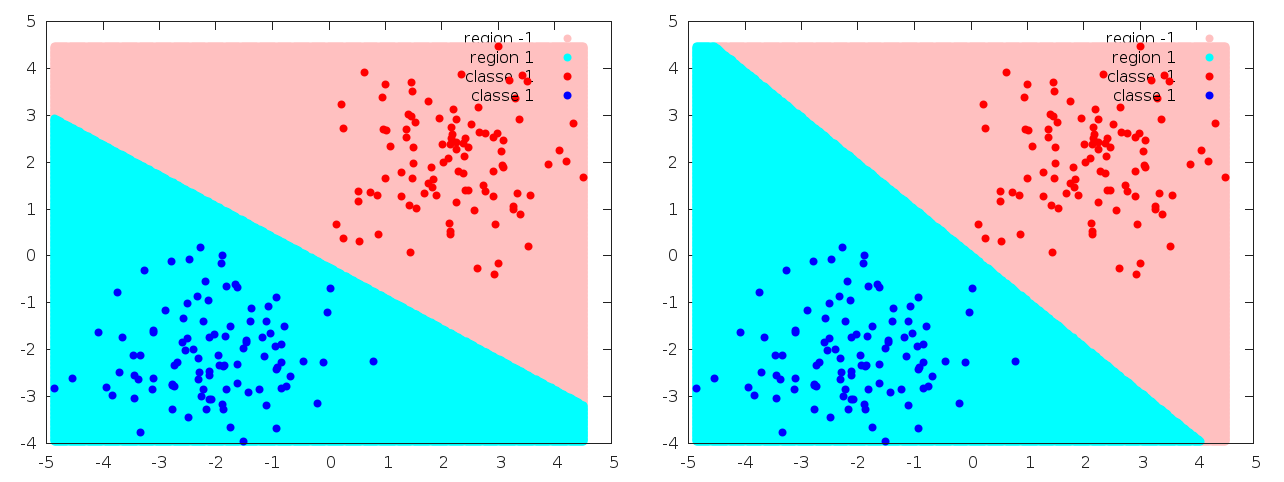

In [23]:
itorch.image{image.load(name1), image.load(name2)}

##B. Modèle linéaire avec noyau, XOR

In [28]:
labels = {-1,1}
gaussParams = {{{0,0},{1,1},labels[1]},
               {{10,10},{1,1},labels[1]},
               {{0,10},{1,1},labels[2]},
               {{10,0},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

In [29]:
nbIter = 1e5
lr = 3e-4
criterion = nn.MarginCriterion()

inputs = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

model = nn.Linear(3,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(inputs)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(inputs, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

name1 = 'kernel_XOR_Margin.png'
plot_binaire_kernel(model, x, y, labels, colors, colorsReg, name1)

In [30]:
nbIter = 1e5
lr = 3e-4
criterion = nn.MSECriterion()

inputs = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

model = nn.Linear(3,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   outputs = model:forward(inputs)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di = model:backward(inputs, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

name2 = 'kernel_XOR_MSE.png'
plot_binaire_kernel(model, x, y, labels, colors, colorsReg, name2)

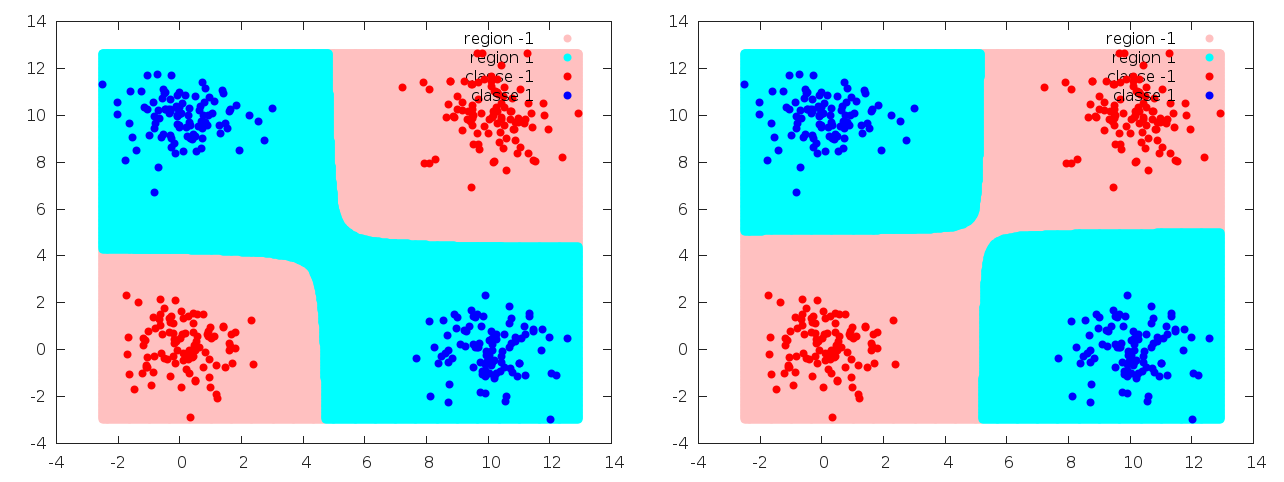

In [31]:
itorch.image{image.load(name1), image.load(name2)}

##C. Réseau de neurones, XOR

In [32]:
nbIter = 2e5
lr = 1e-2
criterion = nn.MarginCriterion()

inputs = x

layer1 = nn.Linear(2,3)
tanh2 = nn.Tanh()
layer3 = nn.Linear(3,1)

for i = 1,nbIter do
   layer1:zeroGradParameters()
   layer3:zeroGradParameters()
   a1 = layer1:forward(inputs)
   a2 = tanh2:forward(a1)
   outputs = layer3:forward(a2)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di3 = layer3:backward(a2, df_do)
   df_di2 = tanh2:backward(a1, df_di3)
   df_di1 = layer1:backward(inputs, df_di2)
   layer1:updateParameters(lr)
   layer3:updateParameters(lr)
   -- print(i,loss)
end

toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
xGridInputs = xGrid

grid1 = layer1:forward(xGridInputs)
grid2 = tanh2:forward(grid1)
yGrid = layer3:forward(grid2)
yGrid = yGrid:sign()

local indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
   local selected = indices[yGrid:eq(labels[i])]
   table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
end

-- Points
local indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end

name1 = 'net_XOR_Margin.png'
gnuplot.pngfigure(name1)
gnuplot.plot(toPlot)
gnuplot.close()

In [33]:
nbIter = 2e5
lr = 1e-2
criterion = nn.MSECriterion()

layer1 = nn.Linear(2,3)
tanh2 = nn.Tanh()
layer3 = nn.Linear(3,1)

for i = 1,nbIter do
   layer1:zeroGradParameters()
   layer3:zeroGradParameters()
   a1 = layer1:forward(x)
   a2 = tanh2:forward(a1)
   outputs = layer3:forward(a2)
   loss = criterion:forward(outputs, y)
   df_do = criterion:backward(outputs, y)
   df_di3 = layer3:backward(a2, df_do)
   df_di2 = tanh2:backward(a1, df_di3)
   df_di1 = layer1:backward(x, df_di2)
   layer1:updateParameters(lr)
   layer3:updateParameters(lr)
   -- print(i,loss)
end

toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
xGridInputs = xGrid

grid1 = layer1:forward(xGridInputs)
grid2 = tanh2:forward(grid1)
yGrid = layer3:forward(grid2)
yGrid = yGrid:sign()

local indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
   local selected = indices[yGrid:eq(labels[i])]
   table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
end

-- Points
local indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end

name2 = 'net_XOR_MSE.png'
gnuplot.pngfigure(name2)
gnuplot.plot(toPlot)
gnuplot.close()


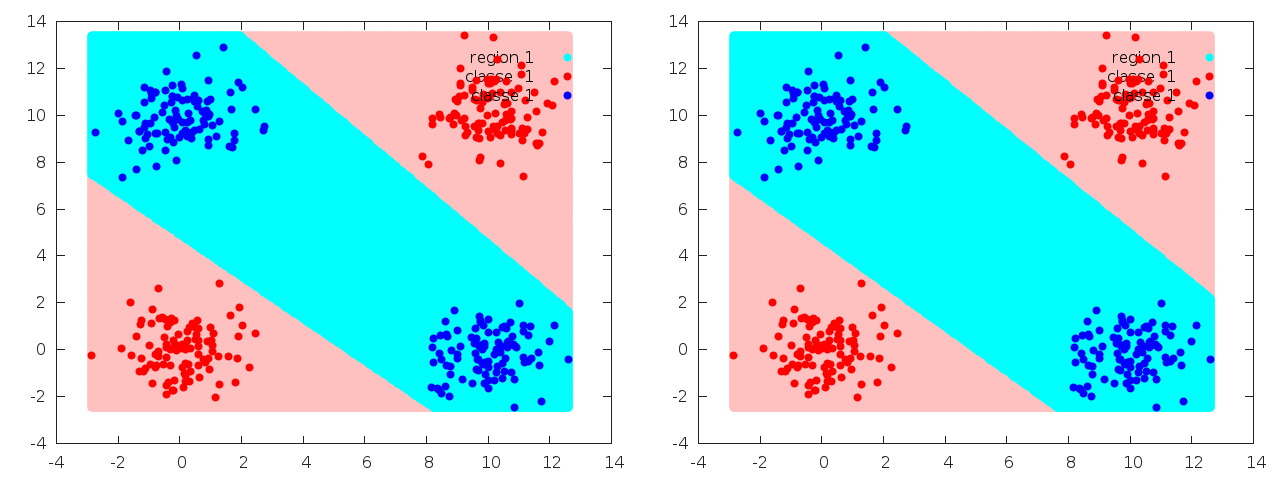

In [34]:
itorch.image{image.load(name1), image.load(name2)}

##D. Modèle Linéaire, Outliers

In [35]:
labels = {-1,1}
gaussParams = {{{2,2},{1,1},labels[1]},{{-2,-2},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 10)
x[1][1] = 20
x[1][2] = 20
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

In [36]:
-- Model Linéaire
nbIter = 100
lr = 1e-1
criterion = nn.MarginCriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   output = model:forward(x)
   loss = criterion:forward(output, y)
   df_do = criterion:backward(output, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
yGrid = model:forward(xGrid)
yGrid = yGrid:sign()
local indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
   local selected = indices[yGrid:eq(labels[i])]
   table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
end

-- Points
local indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end

name1 = 'linear_outliers_margin.png'
gnuplot.pngfigure(name1)
gnuplot.plot(toPlot)
gnuplot.close()

In [39]:
nbIter = 1000
lr = 1e-2
criterion = nn.MSECriterion()

model = nn.Linear(2,1)
for i = 1,nbIter do
   model:zeroGradParameters()
   output = model:forward(x)
   loss = criterion:forward(output, y)
   df_do = criterion:backward(output, y)
   df_di = model:backward(x, df_do)
   model:updateParameters(lr)
   --print(i,loss)
end

toPlot = {}
-- Region
xGrid = getRegionGrid(x,500)
yGrid = model:forward(xGrid)
yGrid = yGrid:sign()
local indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
for i = 1, #labels do
   local selected = indices[yGrid:eq(labels[i])]
   table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
end

-- Points
local indices = torch.linspace(1,y:size(1),y:size(1)):long()
for i = 1, #labels do
   local selected = indices[y:eq(labels[i])]
   table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
end

name2 = 'linear_outliers_mse.png'
gnuplot.pngfigure(name2)
gnuplot.plot(toPlot)
gnuplot.close()

On constate ci-dessous que le modèle linéaire avec critère de marge (à gauche) est capable d'apprendre une frontière de décision qui sépare au mieux les deux classes, car l'outlier n'est pas pris en compte quand il est bien classé. Au contraire, comme ce même outlier bien classé est pris très fortement en compte dans le calcul de l'erreur par le critère MSE, l'autre modèle linéaire (à droite) n'est pas capable d'apprendre une frontière de décision satisfaisante. 

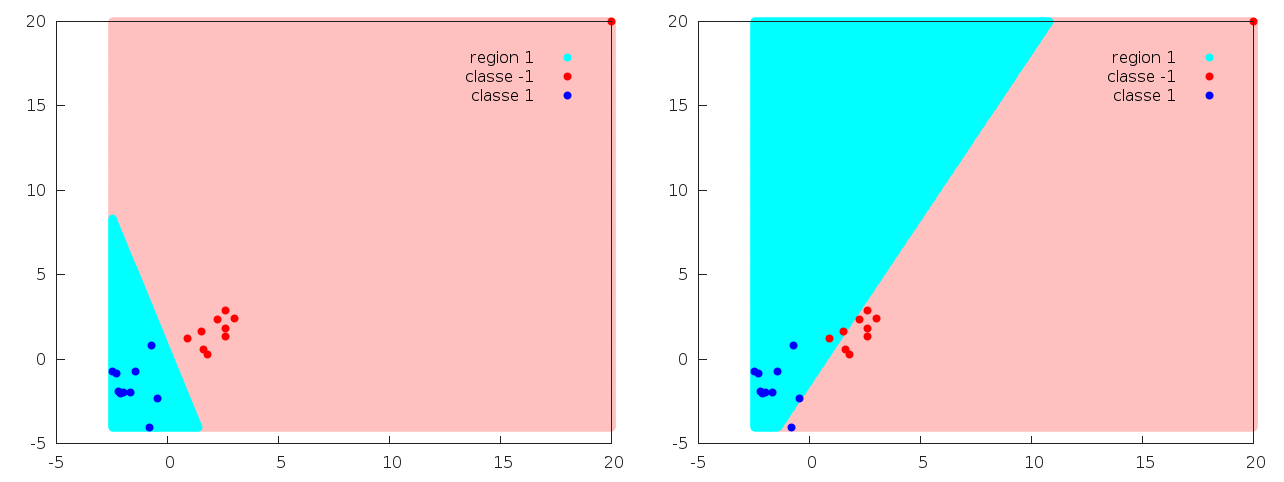

In [40]:
itorch.image{image.load(name1), image.load(name2)}

# Conclusion

La comparaison des frontières de décisions du modèle linéaire, linéaire avec noyau, réseau de neurones deux couches et réseau de neurones trois couches, nous a permis de mettre en évidence leur capacité à apprendre des données en deux dimensions plus ou moins complexes comme le problème du XOR ou de la Spirale. Nous avons notamment pu constater que le modèle linéaire avec noyau et que le réseau de neurones deux couches peuvent apprendre des frontières de décision satisfaisantes pour le problème du XOR, mais que ce ne sont pas les mêmes. En effet, les premières couches des réseaux de neurones apprennent des représentations qui diffèrent de celles des noyaux codées manuellement.

De plus, la comparaison des frontières de décisions des précédents modèles en fonction du critère des moindres carrés ou à marge, nous a permis de comprendre leur différence. Le premier critère permet de minimiser la distance entre $f(x)$ et son label $y$, et pénalise très fortement les outliers bien classés. Le second critère pénalise uniquement les exemples mal classés ou ceux qui sont bien classés mais dont le produit $f(x)*y$ est inférieur à une marge. Cette dernière est égale à 1 dans le cas du critère Hinge Loss.